<a href="https://colab.research.google.com/github/Emsh1379/Stock_prediction/blob/main/Stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance -q
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import yfinance as yf

# Visualize Data

In [ ]:
ms = yf.download("GOOG",
            start = "2012-01-01",
            end ="2021-12-31",
            progress = False )
df = ms[["Adj Close","Open","Close","High","Low"]].round(3)
df['Date']= df.index
df.head()

,Adj Close,Open,Close,High,Low,Date
Date,,,,,,
2012-01-03,16.573,16.263,16.573,16.641,16.248,2012-01-03
2012-01-04,16.645,16.564,16.645,16.694,16.454,2012-01-04
2012-01-05,16.414,16.491,16.414,16.537,16.344,2012-01-05
2012-01-06,16.190,16.417,16.190,16.438,16.184,2012-01-06
2012-01-09,15.503,16.102,15.503,16.115,15.473,2012-01-09


<Axes: xlabel='Date'>

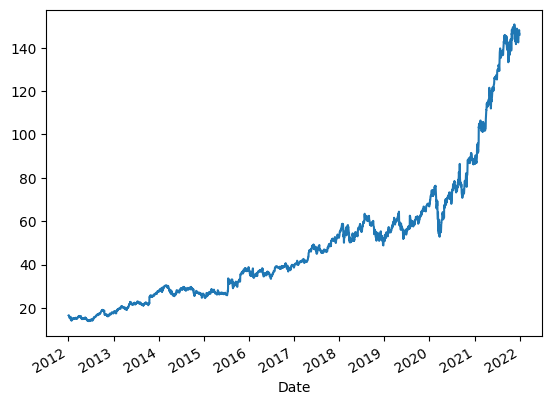

In [ ]:
df.Close.plot()

#SVM

R2 score: 0.93471250801891
Mean absolute error: 4.0326415294603


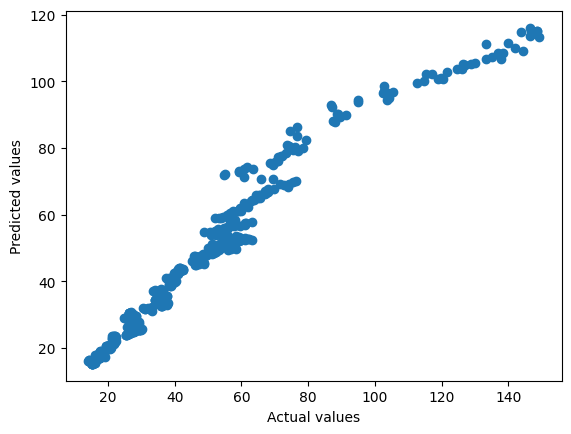

In [ ]:
# build model of svm for date and close values

from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
# split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(
    df[['Date']], df['Close'], test_size=0.2, random_state=42)
# fit SVR model on training data
model = SVR()
model.fit(x_train, y_train)
# make predictions on test data
y_pred = model.predict(x_test)
# evaluate model performance
print('R2 score:', model.score(x_test, y_test))
print('Mean absolute error:', np.mean(np.abs(y_test - y_pred)))
# plot predicted vs actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()


<Axes: xlabel='Date'>

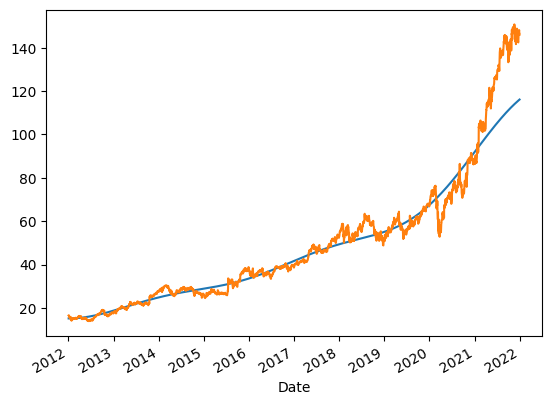

In [ ]:
df['Prediction'] = model.predict(df[['Date']])
df.Prediction.plot()
df.Close.plot()


# Train Data and Test Data split

In [ ]:
# Determin ratio of train to test ratio
ratio = 0.8
split_point = int(df.Close.values.reshape(-1,1).shape[0] * ratio)
train_df = df[:split_point].Close.values.reshape(-1,1)
test_df = df[split_point:].Close.values.reshape(-1,1)


In [ ]:
X_train = []
y_train = []
y_steps = 5
X_steps = 10
for i in range(X_steps, len(train_df) - y_steps + 1):
  X_train.append(train_df[i-X_steps:i,0])
  y_train.append(train_df[i:i+y_steps,0])

X = df.Close.values
X = X[len(X)-len(test_df)-X_steps:]
X = X.reshape(-1,1)

X_test = []
y_test = []
for i in range(X_steps, len(test_df) - y_steps + X_steps + 1):
  X_test.append(X[i-X_steps:i,0])
  y_test.append(X[i:i+y_steps,0])






In [ ]:
test_df[-15:,0]

array([148.106, 148.675, 146.704, 144.971, 147.368, 144.839, 142.803,
       142.402, 144.221, 146.949, 147.143, 148.064, 146.448, 146.505,
       146.003])

In [ ]:
X_test[-1]


array([148.106, 148.675, 146.704, 144.971, 147.368, 144.839, 142.803,
       142.402, 144.221, 146.949])

In [ ]:
y_test[-1]


array([147.143, 148.064, 146.448, 146.505, 146.003])

In [ ]:
np.array(X_train).shape


(1998, 10)

In [ ]:
def ts_data(df,X_steps,y_steps):
  split_point = int(df.Close.values.reshape(-1,1).shape[0] * ratio)
  train_df = df[:split_point].Close.values.reshape(-1,1)
  test_df = df[split_point:].Close.values.reshape(-1,1)

  sc = MinMaxScaler(feature_range=(0,1))
  train_df = sc.fit_transform(train_df)


  X_train = []
  y_train = []
  for i in range(X_steps, len(train_df) - y_steps + 1):
    X_train.append(train_df[i-X_steps:i,0])
    y_train.append(train_df[i:i+y_steps,0])
  X_train = np.array(X_train)
  y_train = np.array(y_train)

  X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)

  X = df.Close.values
  X = X[len(X)-len(test_df)-X_steps:]
  X = X.reshape(-1,1)
  X = sc.transform(X)

  X_test = []
  y_test = []
  for i in range(X_steps, len(test_df) - y_steps + X_steps + 1):
    X_test.append(X[i-X_steps:i,0])
    y_test.append(X[i:i+y_steps,0])
  X_test = np.array(X_test)
  y_test = np.array(y_test)

  X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

  return X_train,y_train,X_test,y_test,sc






# Determine X_steps and y_steps

In [ ]:
X_steps,y_steps = 6,2

In [ ]:
X_train,y_train,X_test,y_test,sc = ts_data(df,X_steps,y_steps)



In [ ]:
X_train.shape



(2005, 6, 1)

In [ ]:
y_train.shape




(2005, 2)

In [ ]:
X_test.shape

(503, 6, 1)

In [ ]:
y_test.shape



(503, 2)

# Simple RNN-Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [ ]:
import keras_tuner
from tensorflow import keras

def build_model(hp):
  model = keras.Sequential()
  for i in range(hp.Int("num_layers", 1, 5)):
    model.add(SimpleRNN(hp.Int(f"units_{i}", min_value=32, max_value=512, step=32), return_sequences=True))
  model.add(SimpleRNN(hp.Int(f"units_{i}", min_value=32, max_value=512, step=32)))
  model.add(keras.layers.Dense(2, activation=hp.Choice("activation", ["relu", "Softmax"])))
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                loss='mean_absolute_error',
                )
  return model


tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    directory='my_dir',
    max_trials=15,
    project_name='simpleRNN_tuning'
    )

In [ ]:
tuner.search(X_train, y_train, epochs=3, validation_data=(X_test,y_test))
best_model = tuner.get_best_models()[0]

Trial 15 Complete [00h 00m 26s]
val_loss: 1.0957860946655273

Best val_loss So Far: 0.4647137522697449
Total elapsed time: 00h 04m 46s


In [ ]:
simple_rnn_model = best_model

In [ ]:
simple_rnn_pred = simple_rnn_model.predict(X_test)
simple_rnn_pred.shape


16/16 [==============================] - 2s 16ms/step


(503, 2)

In [ ]:
def prediction_plot(predictions):
  fig , ax = plt.subplots(figsize=(10,5))
  ax.plot(df[split_point:].index[:len(y_test)],
          sc.inverse_transform(y_test[:,0].reshape(-1,1)),label = "Real")
  ax.plot(df[split_point:].index[:len(y_test)],
          sc.inverse_transform(predictions[:,0].reshape(-1,1)),label = "Prediction")

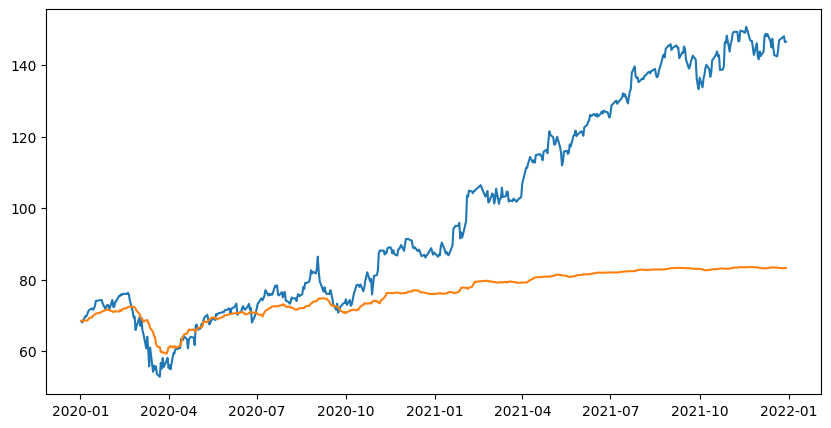

In [ ]:
prediction_plot(simple_rnn_pred)



In [ ]:
simple_rnn_model.evaluate(X_test,y_test)

16/16 [==============================] - 1s 16ms/step - loss: 0.4647


0.4647137522697449

In [ ]:
simple_rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 6, 384)            148224    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 6, 160)            87200     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 6, 416)            240032    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 6, 512)            475648    
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 6, 32)             17440     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 2)                 6

# LSTM

In [ ]:
from keras.layers import LSTM

In [ ]:
import keras_tuner
from tensorflow import keras

def build_model(hp):
  model = keras.Sequential()
  for i in range(hp.Int('num_layers', 1, 5)):
    model.add(LSTM(hp.Int(f"units_{i}", min_value=32, max_value=512, step=32), return_sequences=True))
  model.add(LSTM(hp.Int(f"units_{i}", min_value=32, max_value=512, step=32)))
  model.add(keras.layers.Dense(2, activation=hp.Choice("activation", ["relu", "Softmax"])))
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                loss='mean_absolute_error',
                )
  return model


tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=15,
    directory='my_dir',
    project_name='LSTM_tuning'
    )

In [ ]:
tuner.search(X_train, y_train, epochs=3, validation_data=(X_test,y_test))
best_model = tuner.get_best_models()[0]
lstm = best_model

Trial 15 Complete [00h 00m 55s]
val_loss: 1.0834742784500122

Best val_loss So Far: 0.0682569146156311
Total elapsed time: 00h 11m 07s


16/16 [==============================] - 2s 15ms/step


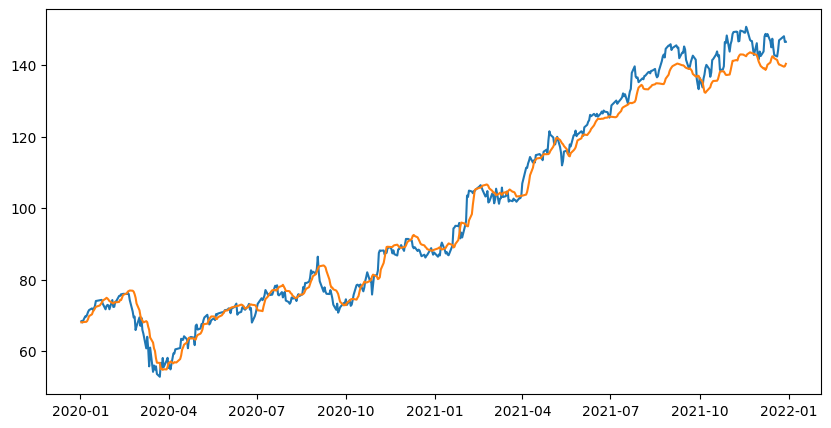

In [ ]:
prediction_plot(lstm.predict(X_test))


In [ ]:
lstm.evaluate(X_test,y_test)

16/16 [==============================] - 1s 16ms/step - loss: 0.0683


0.0682569146156311

In [ ]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 160)            103680    
                                                                 
 lstm_1 (LSTM)               (None, 160)               205440    
                                                                 
 dense (Dense)               (None, 2)                 322       
                                                                 
Total params: 309442 (1.18 MB)
Trainable params: 309442 (1.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Combimition of LSTM and GRU

In [ ]:
from keras.layers import GRU
import keras_tuner
from tensorflow import keras

def build_model(hp):
  model = keras.Sequential()
  for i in range(hp.Int('num_layers', 1, 5)):
    model.add(GRU(hp.Int(f"units_{i}", min_value=32, max_value=512, step=32), return_sequences=True))
    model.add(LSTM(hp.Int(f"units_{i}", min_value=32, max_value=512, step=32), return_sequences=True))
  model.add(GRU(hp.Int(f"units_{i}", min_value=32, max_value=512, step=32)))
  model.add(keras.layers.Dense(2, activation=hp.Choice("activation", ["relu", "Softmax"])))
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                loss='mean_absolute_error',
                )
  return model


In [ ]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=15,
    directory='my_dir',
    project_name='Combined_tuning'
    )

In [ ]:
tuner.search(X_train, y_train, epochs=3, validation_data=(X_test,y_test))
best_model = tuner.get_best_models()[0]
Combined = best_model


Trial 15 Complete [00h 00m 58s]
val_loss: 0.09135487675666809

Best val_loss So Far: 0.053378522396087646
Total elapsed time: 00h 18m 55s


16/16 [==============================] - 6s 40ms/step


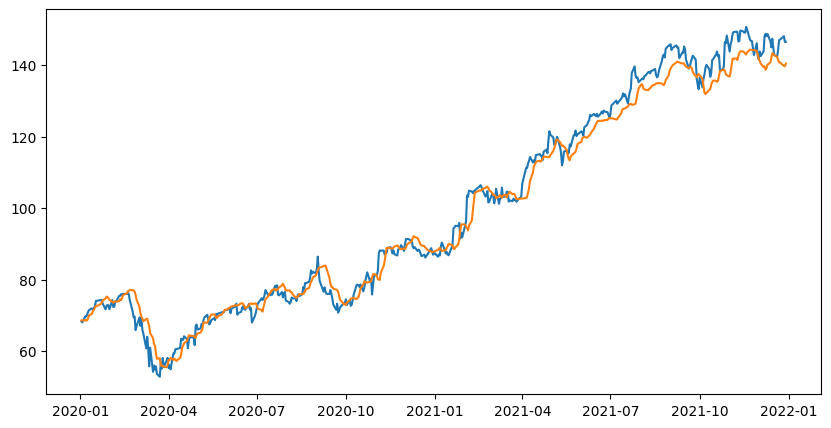

In [ ]:
prediction_plot(Combined.predict(X_test))

In [ ]:
Combined.evaluate(X_test,y_test)

16/16 [==============================] - 3s 44ms/step - loss: 0.0534


0.053378522396087646

In [ ]:
Combined.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 6, 128)            50304     
                                                                 
 lstm (LSTM)                 (None, 6, 128)            131584    
                                                                 
 gru_1 (GRU)                 (None, 6, 416)            681408    
                                                                 
 lstm_1 (LSTM)               (None, 6, 416)            1386112   
                                                                 
 gru_2 (GRU)                 (None, 416)               1040832   
                                                                 
 dense (Dense)               (None, 2)                 834       
                                                                 
Total params: 3291074 (12.55 MB)
Trainable params: 32910

# GRU

In [ ]:
from keras.layers import GRU
import keras_tuner
from tensorflow import keras

def build_model(hp):
  model = keras.Sequential()
  for i in range(hp.Int('num_layers', 1, 5)):
    model.add(GRU(hp.Int(f"units_{i}", min_value=32, max_value=512, step=32), return_sequences=True))
  model.add(GRU(hp.Int(f"units_{i}", min_value=32, max_value=512, step=32)))
  model.add(keras.layers.Dense(2, activation=hp.Choice("activation", ["relu", "Softmax"])))
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                loss='mean_absolute_error',
                )
  return model


tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=15,
    directory='my_dir',
    project_name='GRU_tuning'
    )

In [ ]:
tuner.search(X_train, y_train, epochs=3, validation_data=(X_test,y_test))
best_model = tuner.get_best_models()[0]
GRU = best_model

Trial 15 Complete [00h 00m 43s]
val_loss: 1.0834742784500122

Best val_loss So Far: 0.058122068643569946
Total elapsed time: 00h 09m 30s


16/16 [==============================] - 5s 26ms/step


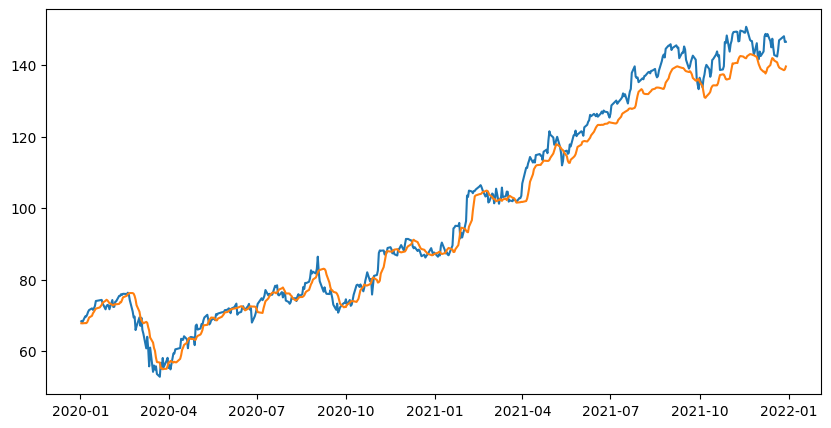

In [ ]:
prediction_plot(GRU.predict(X_test))

In [ ]:
GRU.evaluate(X_test,y_test)

16/16 [==============================] - 2s 38ms/step - loss: 0.0581


0.058122068643569946

In [ ]:
GRU.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 6, 96)             28512     
                                                                 
 gru_1 (GRU)                 (None, 6, 128)            86784     
                                                                 
 gru_2 (GRU)                 (None, 6, 96)             65088     
                                                                 
 gru_3 (GRU)                 (None, 6, 416)            641472    
                                                                 
 gru_4 (GRU)                 (None, 416)               1040832   
                                                                 
 dense (Dense)               (None, 2)                 834       
                                                                 
Total params: 1863522 (7.11 MB)
Trainable params: 186352

# Compare mean absolute error of models

16/16 [==============================] - 1s 41ms/step - loss: 0.0534


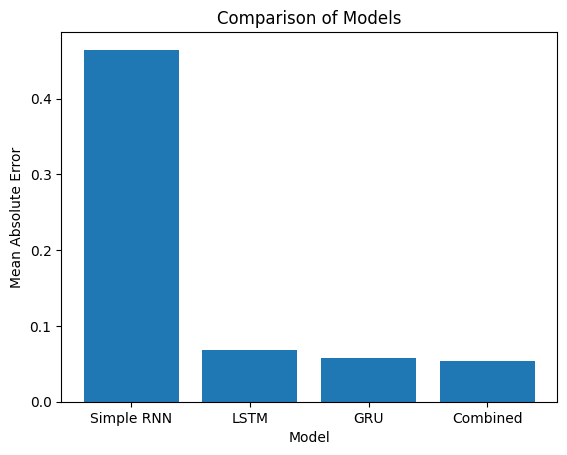

In [ ]:
#Compare mean absolute error of models

models = [simple_rnn_model, lstm, GRU, Combined]
model_names = ["Simple RNN", "LSTM", "GRU", "Combined"]
mae = []
for model, name in zip(models, model_names):
  mae.append(model.evaluate(X_test, y_test))

plt.bar(model_names, mae)
plt.xlabel("Model")
plt.ylabel("Mean Absolute Error")
plt.title("Comparison of Models")
plt.show()


# Tain plot

63/63 [==============================] - 3s 45ms/step


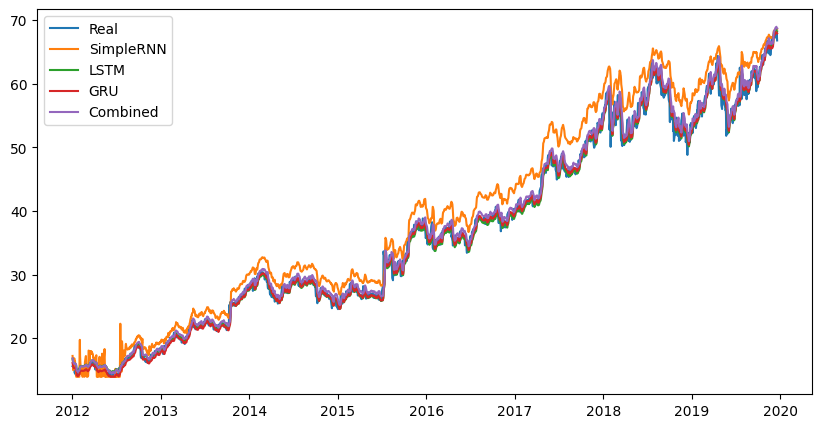

In [ ]:
fig , ax = plt.subplots(figsize=(10,5))
ax.plot(df[:split_point].index[:len(y_train)],
        sc.inverse_transform(y_train[:,0].reshape(-1,1)),label = "Real")
ax.plot(df[:split_point].index[:len(y_train)],
        sc.inverse_transform(simple_rnn_model.predict(X_train)[:,0].reshape(-1,1)),label = "SimpleRNN")
ax.plot(df[:split_point].index[:len(y_train)],
        sc.inverse_transform(lstm.predict(X_train)[:,0].reshape(-1,1)),label = "LSTM")
ax.plot(df[:split_point].index[:len(y_train)],
        sc.inverse_transform(GRU.predict(X_train)[:,0].reshape(-1,1)),label = "GRU")
ax.plot(df[:split_point].index[:len(y_train)],
        sc.inverse_transform(Combined.predict(X_train)[:,0].reshape(-1,1)),label = "Combined")
plt.legend()

# Test plot

16/16 [==============================] - 1s 42ms/step


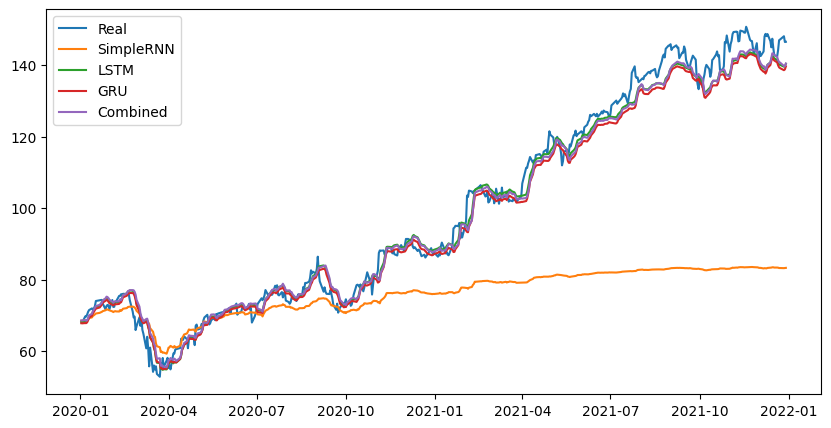

In [ ]:
fig , ax = plt.subplots(figsize=(10,5))
ax.plot(df[split_point:].index[:len(y_test)],
        sc.inverse_transform(y_test[:,0].reshape(-1,1)),label = "Real")
ax.plot(df[split_point:].index[:len(y_test)],
        sc.inverse_transform(simple_rnn_model.predict(X_test)[:,0].reshape(-1,1)),label = "SimpleRNN")
ax.plot(df[split_point:].index[:len(y_test)],
        sc.inverse_transform(lstm.predict(X_test)[:,0].reshape(-1,1)),label = "LSTM")
ax.plot(df[split_point:].index[:len(y_test)],
        sc.inverse_transform(GRU.predict(X_test)[:,0].reshape(-1,1)),label = "GRU")
ax.plot(df[split_point:].index[:len(y_test)],
        sc.inverse_transform(Combined.predict(X_test)[:,0].reshape(-1,1)),label = "Combined")
plt.legend()


# Deep AR

In [1]:
!pip install yfinance -q

In [2]:
!pip install PyYAML==5.4.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 3.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [3]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 814.3/814.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 k

In [22]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import darts
from darts.utils.likelihood_models import GaussianLikelihood
from darts.models import RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.missing_values import fill_missing_values
from darts import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mae,mape

In [8]:
ms = yf.download("GOOG",
            start = "2012-01-01",
            end ="2021-12-31",
            progress = False )
df = ms[["Adj Close","Open","Close","High","Low"]].round(3)
df['Date']= df.index
df.head()

,Adj Close,Open,Close,High,Low,Date
Date,,,,,,
2012-01-03,16.573,16.263,16.573,16.641,16.248,2012-01-03
2012-01-04,16.645,16.564,16.645,16.694,16.454,2012-01-04
2012-01-05,16.414,16.491,16.414,16.537,16.344,2012-01-05
2012-01-06,16.190,16.417,16.190,16.438,16.184,2012-01-06
2012-01-09,15.503,16.102,15.503,16.115,15.473,2012-01-09


In [9]:
df_daily = df.groupby(df.index.astype(str).str.split(" ").str[0]).mean().reset_index()

<ipython-input-9-74f2a467670c>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_daily = df.groupby(df.index.astype(str).str.split(" ").str[0]).mean().reset_index()


In [10]:
df_daily

,Date,Adj Close,Open,Close,High,Low
0,2012-01-03,16.573,16.263,16.573,16.641,16.248
1,2012-01-04,16.645,16.564,16.645,16.694,16.454
2,2012-01-05,16.414,16.491,16.414,16.537,16.344
3,2012-01-06,16.190,16.417,16.190,16.438,16.184
4,2012-01-09,15.503,16.102,15.503,16.115,15.473
...,...,...,...,...,...,...
2511,2021-12-23,147.143,147.089,147.143,148.573,146.951
2512,2021-12-27,148.064,147.464,148.064,148.426,147.250
2513,2021-12-28,146.448,148.374,146.448,148.374,145.936
2514,2021-12-29,146.505,146.430,146.505,147.184,145.505


In [11]:
df_ts = fill_missing_values(
    TimeSeries.from_dataframe(df_daily,
                              time_col="Date",
                              value_cols="Close",
                              fill_missing_dates=True,
                              freq='D')
    ,"auto")
df_ts = df_ts.astype(np.float32)

scaler_ts = Scaler()
df_ts_transformed = scaler_ts.fit_transform(df_ts)

In [12]:
train_ts,val_ts = df_ts_transformed.split_after(0.8)

<Axes: xlabel='Date'>

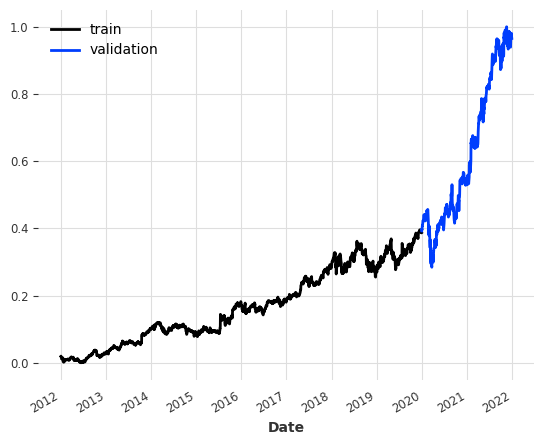

In [13]:
train_ts.plot(label="train")
val_ts.plot(label="validation")

In [14]:
fut_cuv = datetime_attribute_timeseries(

   df_ts_transformed, attribute = "day", one_hot=True, dtype=np.float32
)

In [15]:
scaler_cov = Scaler()
fut_cuv_transformed = scaler_cov.fit_transform(fut_cuv)
train_cov , val_cov = fut_cuv_transformed.split_after(0.8)
train_cov.pd_dataframe()

component,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-04,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-05,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-07,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2019-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2019-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
grisdsearch

In [16]:
df_rnn_model = RNNModel(
    model_name="LSTM",
    hidden_dim=30,
    dropout=0,
    n_rnn_layers=3,
    batch_size=32,
    n_epochs=20,
    optimizer_kwargs={"lr": 1e-3},
    training_length=250,
    input_chunk_length=200,
    likelihood=GaussianLikelihood(),
)

In [17]:
df_rnn_model.fit(series=train_ts,future_covariates=train_cov)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 5.6 K 
4 | V             | Linear           | 62    
---------------------------------------------------
5.7 K     Trainable params
0         Non-trainable params
5.7 K     Total params
0.023     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


RNNModel(model=RNN, hidden_dim=30, n_rnn_layers=3, dropout=0, training_length=250, model_name=LSTM, batch_size=32, n_epochs=20, optimizer_kwargs={'lr': 0.001}, input_chunk_length=200, likelihood=GaussianLikelihood(prior_mu=None, prior_sigma=None, prior_strength=1.0, beta_nll=0.0))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

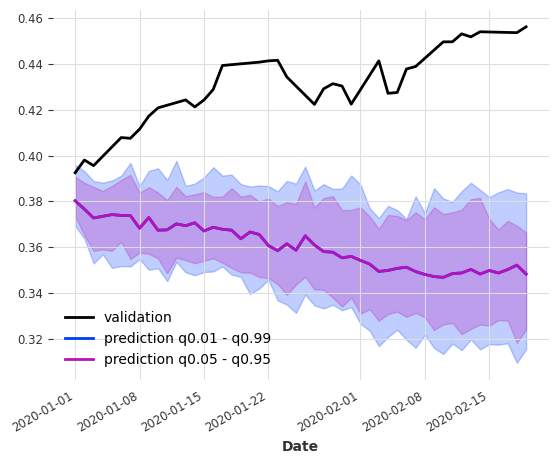

In [41]:
pred_ts = df_rnn_model.predict(50,num_samples=50,future_covariates=fut_cuv_transformed)
val_ts.slice_intersect(pred_ts).plot(label="validation")
pred_ts.plot(label="prediction q0.01 - q0.99",low_quantile=0.01, high_quantile=0.99)
pred_ts.plot(label="prediction q0.05 - q0.95",low_quantile=0.05, high_quantile=0.95)
plt.legend()